In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ','PPDIAT', 'PPPHY', 'PPMRUB','MORTPHY', 'MORTMRUB', 'MORTDIAT','diatoms', 'flagellates', 'ciliates']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
        
            for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ','MORTPHY', 'MORTMRUB', 'MORTDIAT']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)

        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
        
            for var in ['PPDIAT', 'PPPHY', 'PPMRUB']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
       
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
        
            for var in ['diatoms', 'flagellates', 'ciliates', ]:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
       
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add total grazing fields
aggregates['TotalGrazing'] = {}
variables.append('TotalGrazing')
for year in years:
    aggregates['TotalGrazing'][year] = sum(aggregates[var][year] for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ'])

aggregates['TotalPP'] = {}
variables.append('TotalPP')
for year in years:
    aggregates['TotalPP'][year] = sum(aggregates[var][year] for var in ['PPDIAT', 'PPPHY', 'PPMRUB'])
    
aggregates['TotalPhytoMortality'] = {}
variables.append('TotalPhytoMortality')
for year in years:
    aggregates['TotalPhytoMortality'][year] = sum(aggregates[var][year] for var in ['MORTPHY', 'MORTMRUB', 'MORTDIAT'])  

    aggregates['PhytoBiomass'] = {}
variables.append('PhytoBiomass')
for year in years:
    aggregates['PhytoBiomass'][year] = sum(aggregates[var][year] for var in ['diatoms', 'flagellates', 'ciliates'])



# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(aggregates['TotalGrazing'][2015][:]))

(898, 398)


In [5]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['TotalGrazing','TotalPP','TotalPhytoMortality','PhytoBiomass','GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ','PPDIAT', 'PPPHY', 'PPMRUB','MORTPHY', 'MORTMRUB', 'MORTDIAT']

In [6]:
aggregates.keys()

dict_keys(['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ', 'PPDIAT', 'PPPHY', 'PPMRUB', 'MORTPHY', 'MORTMRUB', 'MORTDIAT', 'diatoms', 'flagellates', 'ciliates', 'TotalGrazing', 'TotalPP', 'TotalPhytoMortality', 'PhytoBiomass'])

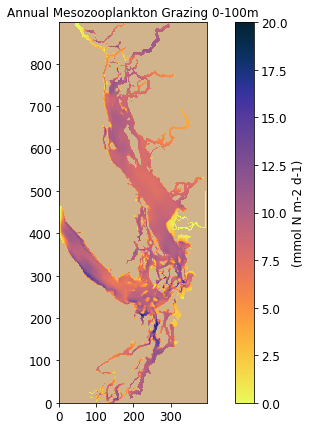

In [7]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=20
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing']['mean']*86400))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Annual Mesozooplankton Grazing 0-100m')
fig.colorbar(m0,ax=ax,label='(mmol N m-2 d-1)')



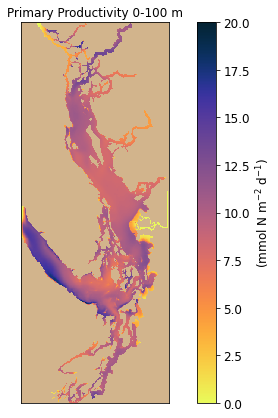

In [8]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=20
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalPP']['mean']*86400))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Primary Productivity 0-100 m')
fig.colorbar(m0,ax=ax,label='(mmol N m$^{-2}$ d$^{-1}$)')

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

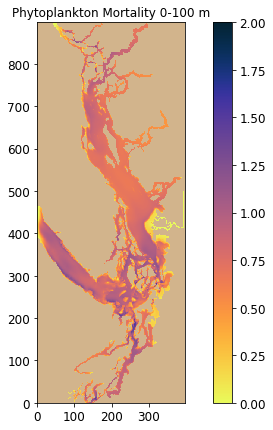

In [9]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=2
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalPhytoMortality']['mean']*86400))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Phytoplankton Mortality 0-100 m')
fig.colorbar(m0,ax=ax,label='')

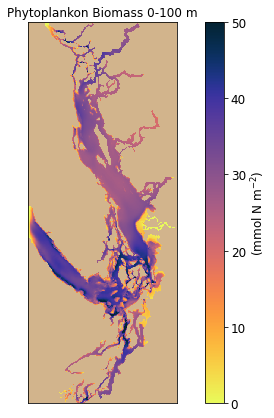

In [10]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=50
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['PhytoBiomass']['mean']))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Phytoplankon Biomass 0-100 m')
fig.colorbar(m0,ax=ax,label='(mmol N m$^{-2}$)')
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

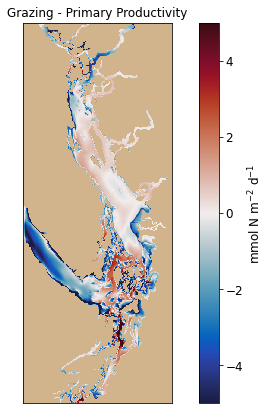

In [22]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=-5
vmax=5
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,(((aggregates['TotalGrazing']['mean']*86400))-(((aggregates['TotalPP']['mean']*86400))-((aggregates['TotalPhytoMortality']['mean']*86400))))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Grazing - Primary Productivity')
fig.colorbar(m0,ax=ax,label='mmol N m$^{-2}$ d$^{-1}$')
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

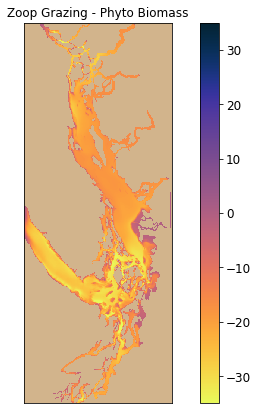

In [23]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=-35
vmax=35
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,(((aggregates['TotalGrazing']['mean']*86400))-(((aggregates['PhytoBiomass']['mean']))-((aggregates['TotalPhytoMortality']['mean']*86400))))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Zoop Grazing - Phyto Biomass')
fig.colorbar(m0,ax=ax,label='')
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)